# COVID-19 Exploratory Data Analysis (EDA)

Plotting some COVID-19 data, focusing on local reagions and looking for turning points.

## Dashboards
There are [many resources](https://github.com/soroushchehresa/awesome-coronavirus) for COVID-19 related data:
- [CDC](https://www.cdc.gov/coronavirus/2019-ncov/cases-updates/cases-in-us.html)
- [Financial Times](https://www.ft.com/coronavirus-latest)
- https://coronavirus.jhu.edu/map.html
- https://gisanddata.maps.arcgis.com/apps/opsdashboard/
- https://www.worldometers.info/coronavirus/
- [USAFacts](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)
- https://nssac.bii.virginia.edu/covid-19/dashboard/
- [StatNews](https://www.statnews.com/2020/03/26/covid-19-tracker/)
- https://ncov2019.live/
- https://covid19dashboards.com/ 
- https://healthweather.us/?mode=Trends
- https://covidtracking.com/data , https://github.com/COVID19Tracking/covid-tracking-data
- https://github.com/aatishb/covidtrends

And data sources:
- https://data.world/resources/coronavirus/
- https://github.com/CSSEGISandData/COVID-19/
- https://www.tableau.com/covid-19-coronavirus-data-resources
- [NYTimes](https://github.com/nytimes/covid-19-data)
- [USAFacts](https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/)

And blog posts:
- https://ourworldindata.org/coronavirus#what-do-we-know-about-the-risk-of-dying-from-covid-19
- https://www.reddit.com/r/dataisbeautiful/comments/fxau85/the_recent_drop_in_us_pneumonia_deaths_is/
- https://hai.stanford.edu/events/covid-19-and-ai-virtual-conference/video-archive?sf120161987=1


**Here we the USAFacts and NYTimes data**

In [1]:
import requests
import io
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# ECDC Data

In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
df = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv', 
                     index_col='date', parse_dates=True)
df = df.rename(columns={'location': 'country', 'total_cases': 'confirmed', 'total_deaths': 'deaths'})
df.tail()

,country,new_cases,new_deaths,confirmed,deaths
date,,,,,
2020-04-28,Zimbabwe,1,0,32,4
2020-04-29,Zimbabwe,0,0,32,4
2020-04-30,Zimbabwe,2,0,34,4
2020-05-01,Zimbabwe,0,0,34,4
2020-05-02,Zimbabwe,0,0,34,4


In [4]:
european_countries = ['Italy', 'Germany', 'France (total)', 'Spain', 'United Kingdom (total)', 
                      'Iran']
large_engl_countries = ['US (total)', 'Canada (total)', 'Australia (total)']
asian_countries = ['Singapore', 'Japan', 'Korea, South', 'Hong Kong']
south_american_countries = ['Argentina', 'Brazil', 'Colombia', 'Chile']

country_groups = [european_countries, large_engl_countries, asian_countries, south_american_countries]

In [5]:
df[df.country == 'United States']

,country,new_cases,new_deaths,confirmed,deaths
date,,,,,
2019-12-31,United States,0,0,0,0
2020-01-01,United States,0,0,0,0
2020-01-02,United States,0,0,0,0
2020-01-03,United States,0,0,0,0
2020-01-04,United States,0,0,0,0
...,...,...,...,...,...
2020-04-28,United States,22541,1369,988451,56245
2020-04-29,United States,24132,2110,1012583,58355
2020-04-30,United States,27326,2611,1039909,60966


In [6]:
table = pd.pivot_table(df[['country','new_cases']], values='new_cases', index=['country'], columns=['date'], aggfunc=np.sum)

## NYTimes State Data

In [7]:
nyt_counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', 
                           index_col='date', parse_dates=True)
nyt_counties.shape, nyt_counties.index[-1]

((106826, 5), Timestamp('2020-05-01 00:00:00'))

In [8]:
annotate = dict(
    s='Based on NYTimes COVID-19 Data ({})'.format(nyt_counties.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.05), xycoords='figure fraction', fontsize=10)

In [9]:
nyt_counties.drop('fips',axis=1,inplace=True)
nyt_counties.tail()

,county,state,cases,deaths
date,,,,
2020-05-01,Sublette,Wyoming,1,0
2020-05-01,Sweetwater,Wyoming,11,0
2020-05-01,Teton,Wyoming,65,1
2020-05-01,Uinta,Wyoming,6,0
2020-05-01,Washakie,Wyoming,4,0


In [10]:
nyt_cases = pd.pivot_table(nyt_counties[['county','state','cases']], 
                       values='cases', index=['state','county'], 
                       columns=['date'], aggfunc=np.sum)
nyt_cases = nyt_cases.T
nyt_cases.shape

(102, 2902)

In [11]:
nyt_deaths = pd.pivot_table(nyt_counties[['county','state','deaths']], 
                       values='deaths', index=['state','county'], 
                       columns=['date'], aggfunc=np.sum)
nyt_deaths = nyt_deaths.T
nyt_deaths.shape

(102, 2902)

In [12]:
nyt_cases.tail()

state      Alabama                                                      \
county     Autauga Baldwin Barbour  Bibb Blount Bullock Butler Calhoun   
date                                                                     
2020-04-27    39.0   168.0    35.0  42.0   34.0    12.0   34.0    90.0   
2020-04-28    40.0   171.0    37.0  42.0   34.0    12.0   45.0    92.0   
2020-04-29    43.0   173.0    37.0  42.0   36.0    12.0   51.0    93.0   
2020-04-30    42.0   174.0    39.0  42.0   37.0    13.0   53.0    93.0   
2020-05-01    42.0   175.0    42.0  42.0   39.0    14.0   65.0    93.0   

state                         ... Wyoming                                 \
county     Chambers Cherokee  ... Lincoln Natrona Niobrara Park Sheridan   
date                          ...                                          
2020-04-27    289.0     14.0  ...     6.0    39.0      1.0  1.0     12.0   
2020-04-28    291.0     15.0  ...     6.0    39.0      1.0  1.0     12.0   
2020-04-29    293.0     15.0  ...     6.0    39.0      1.0  1.0     12.0   
2020-04-30    291.0     15.0  ...     6.0    39.0      1.0  1.0     12.0   
2020-05-01    290.0     15.0  ...     6.0    39.0      1.0  1.0     12.0   

state                                                
county     Sublette Sweetwater Teton Uinta Washakie  
date                                                 
2020-04-27      1.0       10.0  64.0   6.0      4.0  
2020-04-28      1.0       10.0  65.0   6.0      4.0  
2020-04-29      1.0       10.0  64.0   6.0      4.0  
2020-04-30      1.0       11.0  65.0   6.0      4.0  
2020-05-01      1.0       11.0  65.0   6.0      4.0  

[5 rows x 2902 columns]

In [13]:
nyt_deaths.tail()

state      Alabama                                                     \
county     Autauga Baldwin Barbour Bibb Blount Bullock Butler Calhoun   
date                                                                    
2020-04-27     3.0     3.0     0.0  0.0    0.0     0.0    1.0     3.0   
2020-04-28     4.0     3.0     0.0  0.0    0.0     0.0    1.0     3.0   
2020-04-29     4.0     2.0     1.0  0.0    0.0     0.0    1.0     3.0   
2020-04-30     4.0     3.0     1.0  0.0    0.0     0.0    1.0     3.0   
2020-05-01     3.0     4.0     1.0  0.0    0.0     0.0    1.0     3.0   

state                         ... Wyoming                                 \
county     Chambers Cherokee  ... Lincoln Natrona Niobrara Park Sheridan   
date                          ...                                          
2020-04-27     18.0      0.0  ...     0.0     0.0      0.0  0.0      0.0   
2020-04-28     19.0      0.0  ...     0.0     0.0      0.0  0.0      0.0   
2020-04-29     21.0      0.0  ...     0.0     0.0      0.0  0.0      0.0   
2020-04-30     21.0      0.0  ...     0.0     0.0      0.0  0.0      0.0   
2020-05-01     21.0      0.0  ...     0.0     0.0      0.0  0.0      0.0   

state                                                
county     Sublette Sweetwater Teton Uinta Washakie  
date                                                 
2020-04-27      0.0        0.0   1.0   0.0      0.0  
2020-04-28      0.0        0.0   1.0   0.0      0.0  
2020-04-29      0.0        0.0   1.0   0.0      0.0  
2020-04-30      0.0        0.0   1.0   0.0      0.0  
2020-05-01      0.0        0.0   1.0   0.0      0.0  

[5 rows x 2902 columns]

In [14]:
def setup(ax):
    # from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-formatters.html
    import matplotlib.dates as mdates

    ax.grid('on', which='minor', axis='x')
    ax.grid('on', which='major', axis='y')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    
def plot_county(conf, dths, state='New York', county='New York City', from_date='2020-03-23', figsize=(10,12)):
    days = conf.loc[from_date:,].index
    conf = conf[state,county].loc[from_date:,]#[state,county]
    dths = dths[state,county].loc[from_date:,]#[state,county]

    fig, ax = plt.subplots(3,1)
    ax_0 = ax[0]
    ax_1 = ax[1]
    ax_2 = ax[2]
    fig.subplots_adjust(hspace=0.3)
    conf_label = 'confirmed '+str(format(int(conf.iloc[-1]),','))
    dths_label = 'deaths '+str(format(int(dths.iloc[-1]),','))
    ax_0 = conf.plot(title=state+' '+county+' COVID19 cumulative count', label=conf_label, c='b', 
                                            legend=True, figsize=figsize, ax=ax_0)
    ax_0 = dths.plot(label=dths_label, c='r', legend=True, ax=ax_0)
    ax_0.set_xticks(days, minor=True)
    setup(ax_0)

    label='confirmed '+str(format(int(round(conf.loc[from_date:].diff().iloc[-1])),','))
    dths_label='deaths '+str(format(int(round(dths.loc[from_date:].diff().iloc[-1])),','))
    ax_1 = conf.diff().plot(title=state+' '+county+' COVID19 confirmed daily count', label=label, c='b', 
                                                    legend=True, ax=ax_1, figsize=figsize,)
    ax_1 = conf.diff().rolling(3).mean().plot(label=' 3 day average', c='grey',legend=True, ax=ax_1)
    ax_1 = dths.diff().plot(label=dths_label, legend=True, c='r', ax=ax_1)
    setup(ax_1)

    conf_pct_change = conf.diff().pct_change()
    dths_pct_change = dths.diff().pct_change()
    conf_label='confirmed '+str(format(round(conf_pct_change.iloc[-1]*100,2),','))+'%'
    dths_label='deaths '+str(format(round(dths_pct_change.iloc[-1]*100,2),','))+'%'
    ax_2 = conf_pct_change.plot(title=state+' '+county+' COVID19 confirmed daily % change', 
                                                          label=conf_label, c='b', legend=True, ax=ax_2)
    ax_2 = dths_pct_change.plot(label=dths_label, c='r', legend=True, ax=ax_2)
    setup(ax_2)
    ax_2.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(1.0))
    ax_2.annotate(**annotate)
    
    return ax

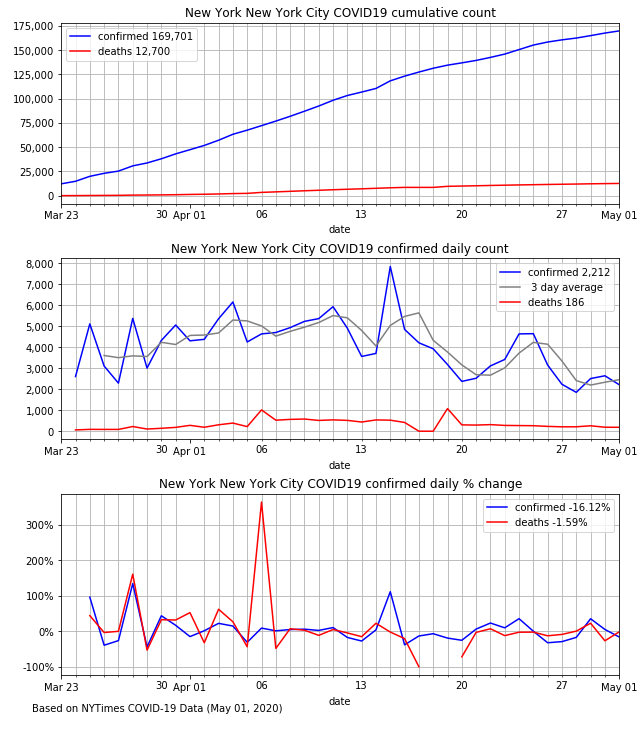

In [15]:
state='New York'
county='New York City'
ax = plot_county(nyt_cases, nyt_deaths, state=state, county=county)
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

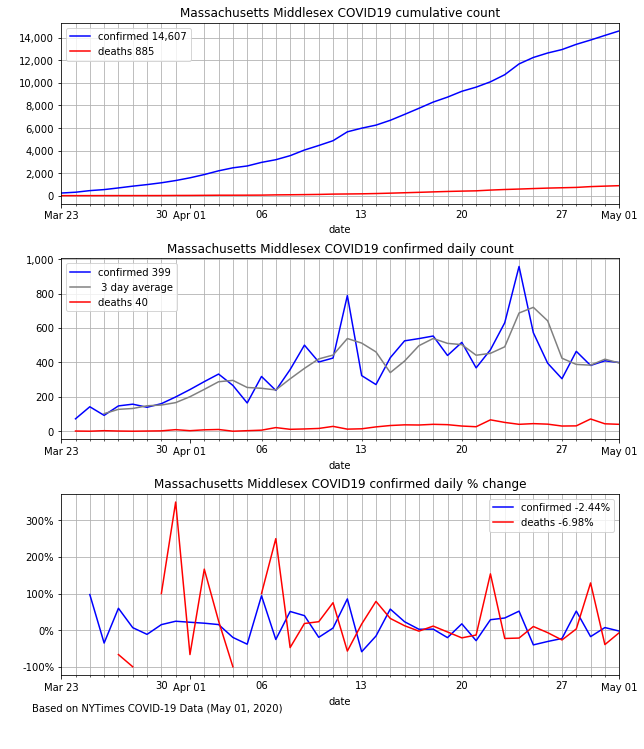

In [16]:
state='Massachusetts'
county='Middlesex'
ax = plot_county(nyt_cases, nyt_deaths,  state=state, county=county)
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

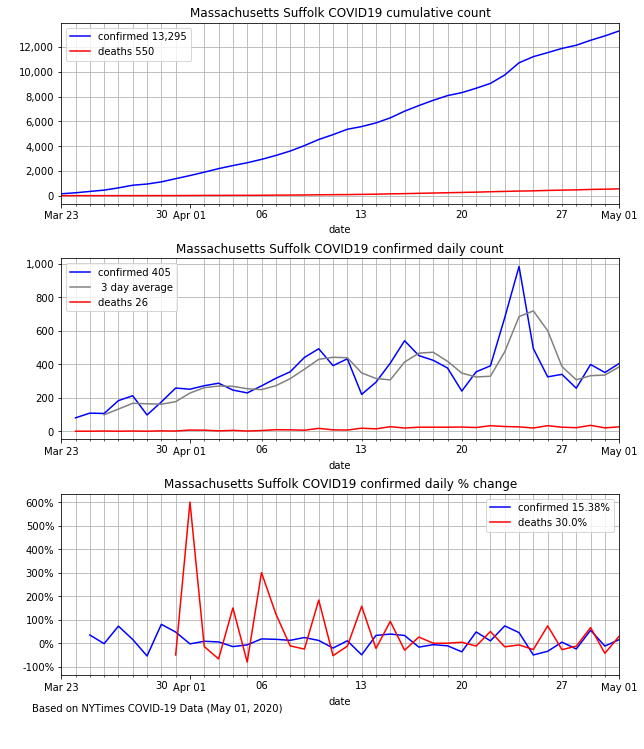

In [17]:
state='Massachusetts'
county='Suffolk'
ax = plot_county(nyt_cases, nyt_deaths, state=state, county=county)
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

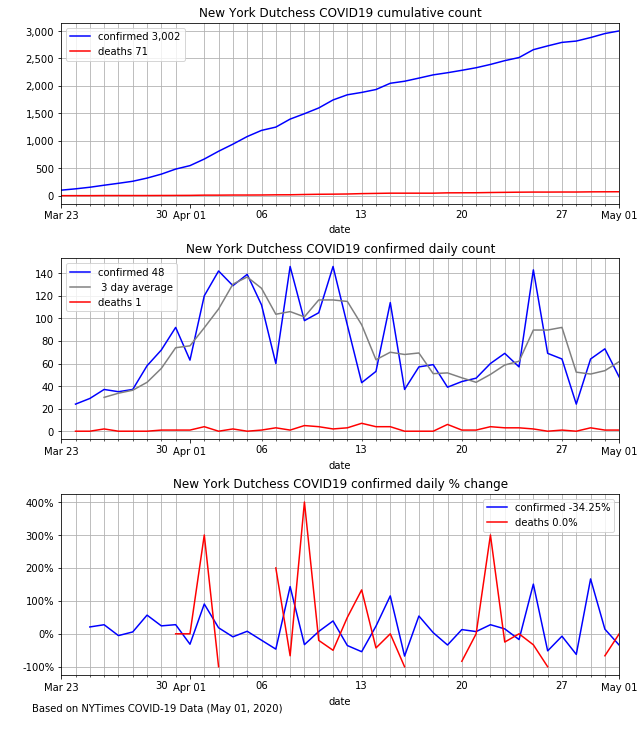

In [18]:
state='New York'
county='Dutchess'
ax = plot_county(nyt_cases, nyt_deaths, state=state, county=county,figsize=(10,12))
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

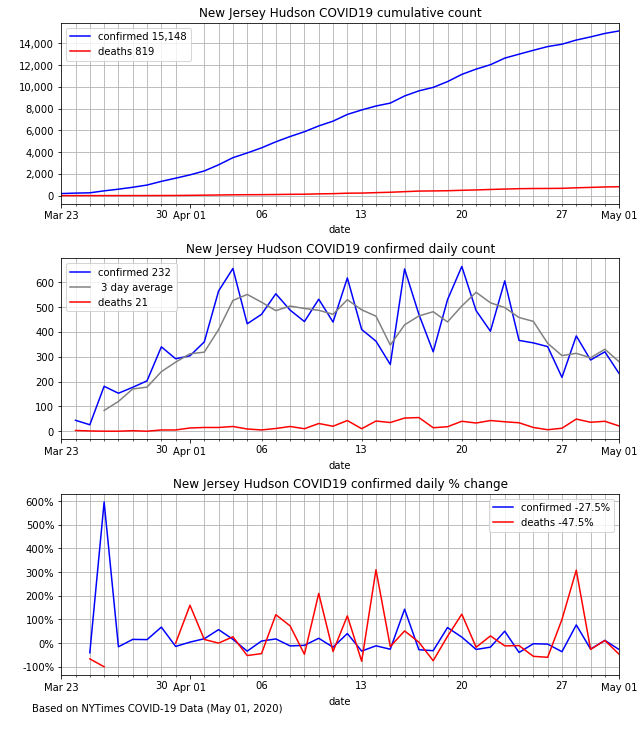

In [19]:
state='New Jersey'
county='Hudson'
ax = plot_county(nyt_cases, nyt_deaths, state=state, county=county,figsize=(10,12))
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

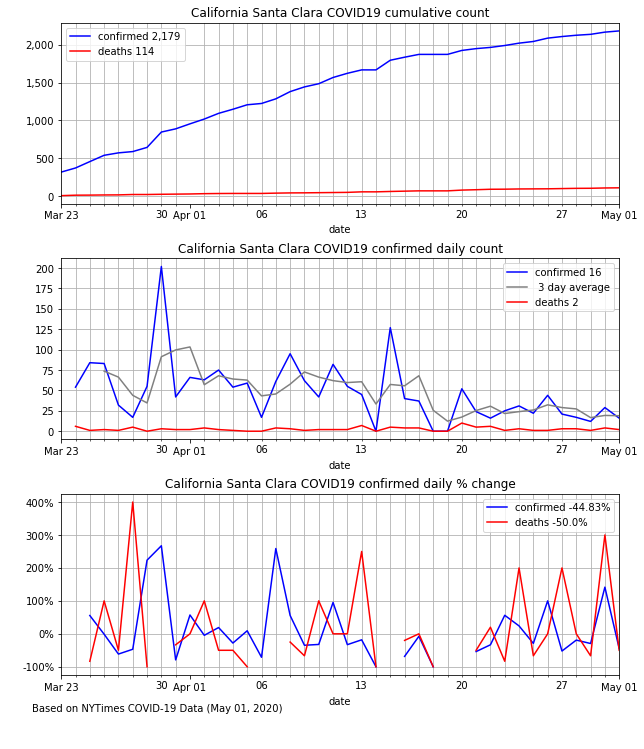

In [20]:
state='California'
county='Santa Clara'
ax = plot_county(nyt_cases, nyt_deaths,  state=state, county=county)
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

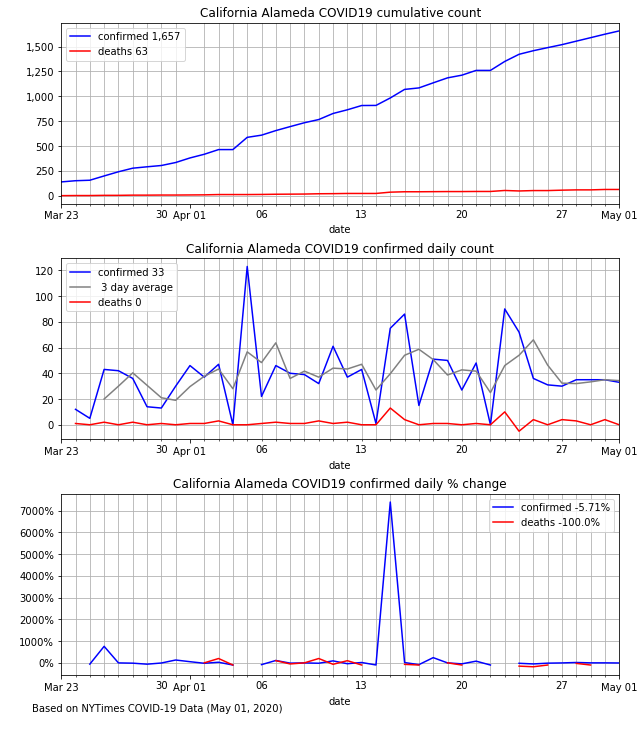

In [21]:
state='California'
county='Alameda'
ax = plot_county(nyt_cases, nyt_deaths,  state=state, county=county)
ax[0].get_figure().savefig(state+'_'+county+'_NYT_COVID19_count.png')

## USAFacts State Data

In [22]:
confirmed_url = 'https://static.usafacts.org/public/data/covid-19/covid_confirmed_usafacts.csv'
deaths_url = 'https://static.usafacts.org/public/data/covid-19/covid_deaths_usafacts.csv'

response = requests.get(confirmed_url)
file_object = io.StringIO(response.content.decode('utf-8'))
confirmed = pd.read_csv(file_object, thousands=',')

response = requests.get(deaths_url)
file_object = io.StringIO(response.content.decode('utf-8'))
deaths = pd.read_csv(file_object, thousands=',')
deaths.shape

(3195, 105)

In [23]:
def adjust_df(df):
    df = df.drop(df.filter(like='Unnamed').columns, axis=1) # drop spurious empty columns
    df = df.drop(df.index[df.countyFIPS.isnull()])          # drop spurious empty rows
    df = df.drop(['countyFIPS','stateFIPS'], axis=1)
    df = df.rename(columns={'County Name': 'County'})       # drop 'County' from column names
    df = df.set_index(['State','County'])
    df = df.T
    df = df.rename(columns=lambda x: x.replace(' County',''))
    df.index = pd.to_datetime(df.index)
    return df

In [24]:
confirmed = adjust_df(confirmed)
deaths    = adjust_df(deaths)
# found some df's had spurisous dupe columns
confirmed.dropna(1,inplace=True)
deaths.dropna(1,inplace=True)
confirmed.index[-1]

Timestamp('2020-05-01 00:00:00')

In [25]:
annotate = dict(
    s='Based on USAFacts COVID-19 Data ({})'.format(confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.1, 0.05), xycoords='figure fraction', fontsize=10)

## US States Data

In [26]:
states_conf = confirmed.groupby(level=0, axis=1).sum()
states_dths = deaths.groupby(level=0, axis=1).sum()

In [27]:
top_states = states_conf.tail(1)
day = top_states.index[0]
top_states = top_states.T
top_states = top_states.sort_values(by=day, ascending=False).index[:3]
top_states

Index(['NY', 'NJ', 'MA'], dtype='object', name='State')

In [28]:
def plot_states(df, figsize=(12,8), title='Confirmed'):
    fig, ax = plt.subplots()
    ax = df.plot(title=title+' COVID19 by State', legend=True, figsize=figsize, ax=ax)
    top_states = df.tail(1)
    day = top_states.index[0]
    top_states = top_states.T
    top_states = top_states.sort_values(by=day, ascending=False).index[:3]
    top_points = df[top_states].tail(1)
    top_points.plot(ax=ax, style='ro')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.legend(loc='upper left', ncol=4)
    ax.grid('on', which='major', axis='y')
    for state, y in zip(list(top_points.columns), top_points.values[0]):
        plt.text(day, y, state)
    return ax

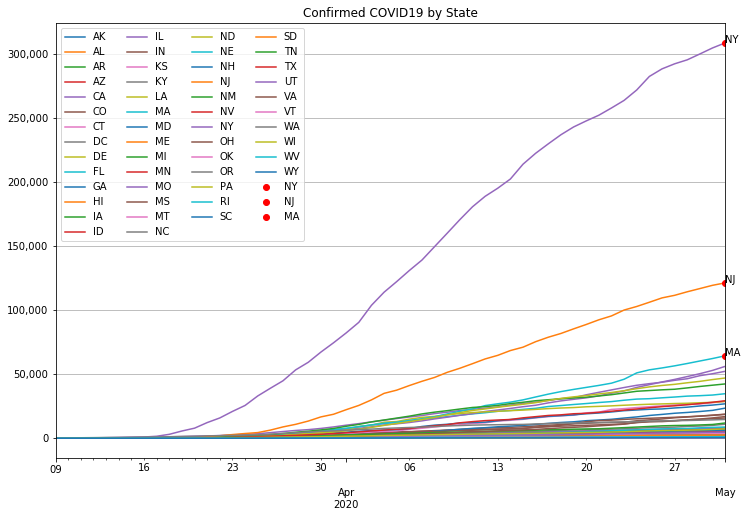

In [29]:
ax = plot_states(states_conf.loc['2020-03-09':,])

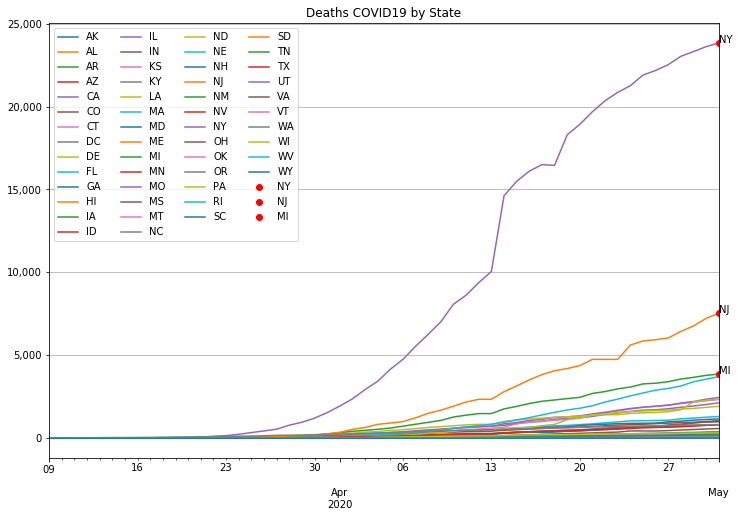

In [30]:
ax = plot_states(states_dths.loc['2020-03-09':,], title='Deaths')

In [31]:
def plot_state(df, state='NY', county=None, label='confirmed', from_date='2020-03-09', figsize=(12,8)):
    days = df.loc[from_date:,].index
    df = df[state].loc[from_date:,]
    
    fig, ax = plt.subplots()
    ax = df.loc[from_date:,].plot(title=state+' COVID19 '+label+' by County', figsize=figsize, ax=ax)
    ax.legend(loc='upper left', ncol=3)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.grid('on', which='major', axis='y')

    last_date = df[-1:].index[0]
    top_state_counties = list(df.sort_values(by=last_date, axis=1, ascending=False).columns[:10])
    if county == None:
        top_county = top_state_counties[0]
    else:
        top_county = county
    
    fig, ax = plt.subplots()
    ax = df.loc[from_date:,top_state_counties].plot(title='top '+state+' COVID19 '+label+' by county', figsize=figsize, ax=ax)
    ax.legend(loc='upper left', ncol=2)
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.grid('on', which='major', axis='y')

    return ax

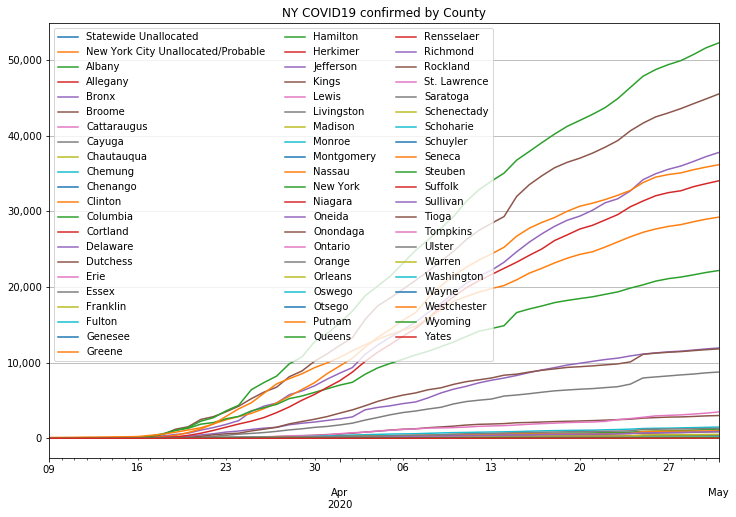

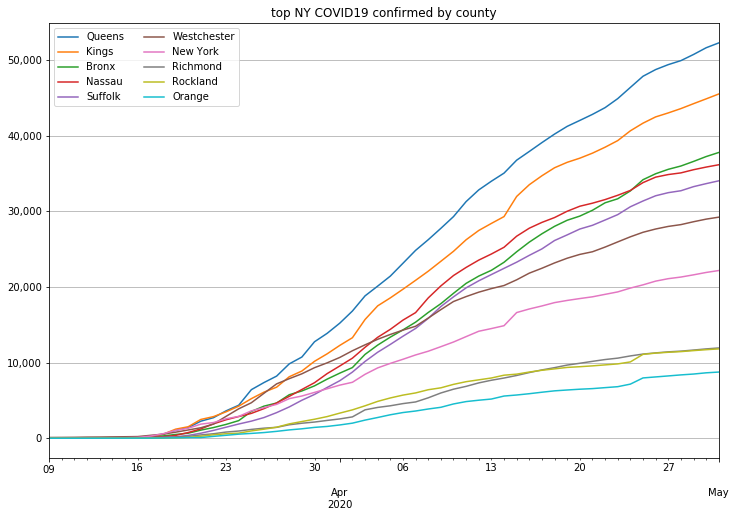

In [32]:
ax = plot_state(confirmed)
ax.get_figure().savefig('NY_confirmed.png')

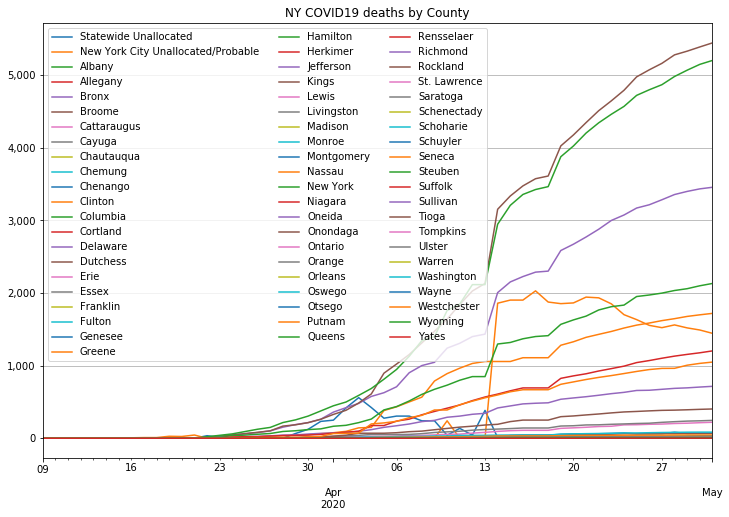

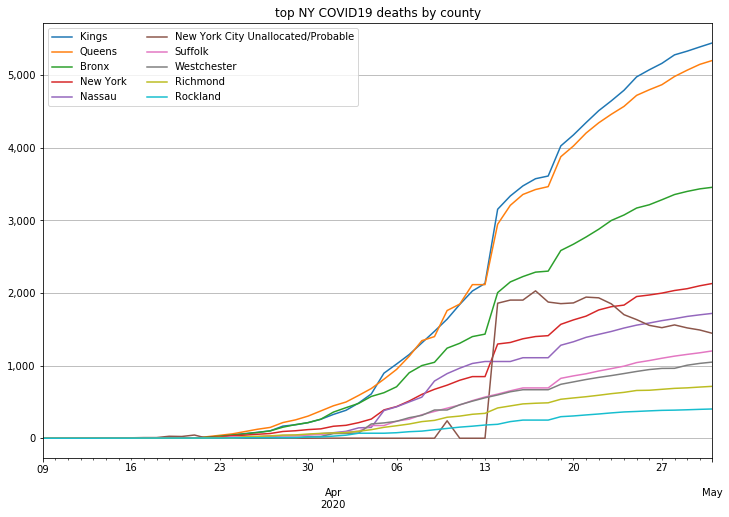

In [33]:
ax = plot_state(deaths, label='deaths')
ax.get_figure().savefig('NY_deaths.png')

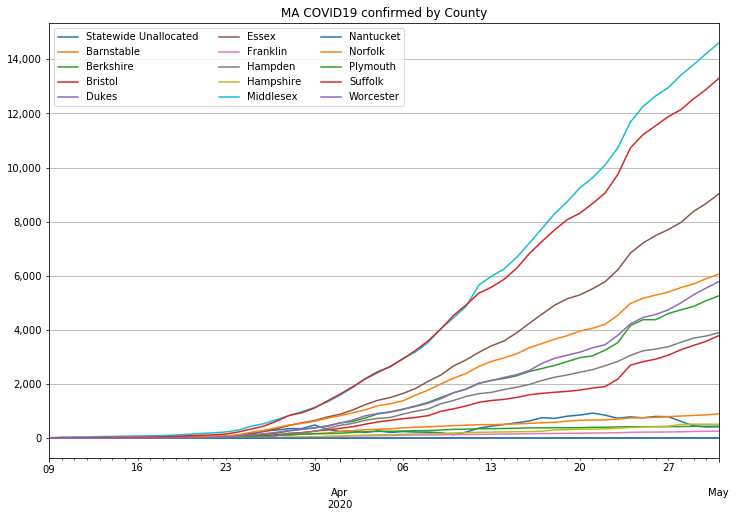

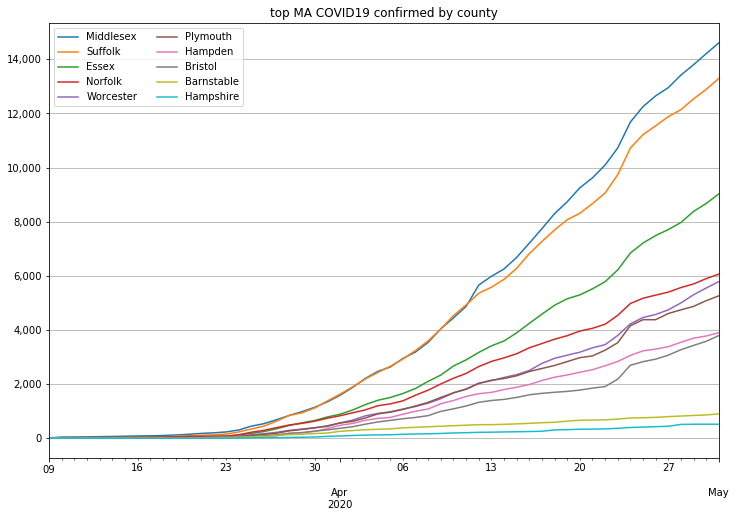

In [34]:
ax = plot_state(confirmed, 'MA')
ax.get_figure().savefig('MA_confirmed.png')

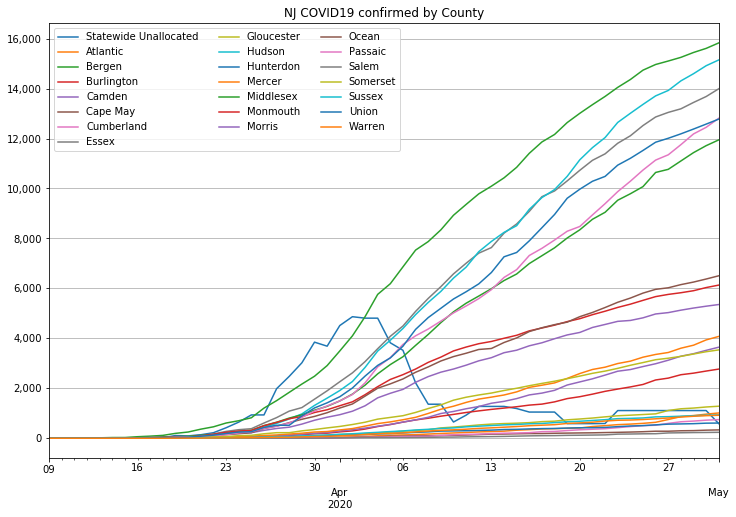

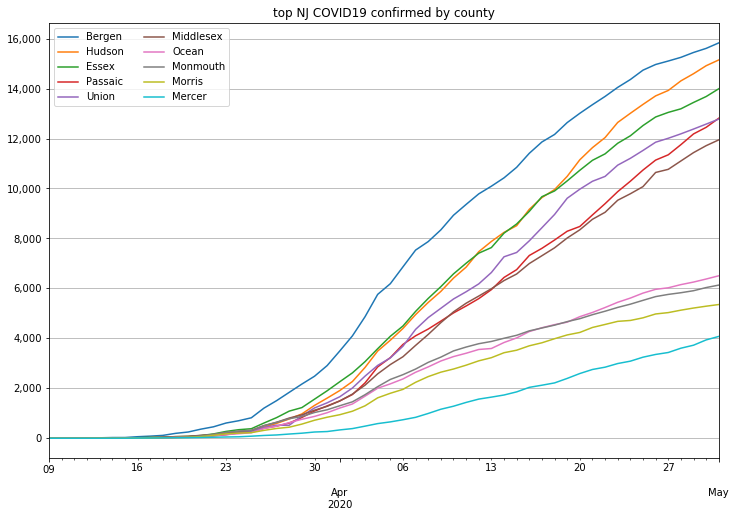

In [35]:
ax = plot_state(confirmed, 'NJ')
ax.get_figure().savefig('NJ_confirmed.png')

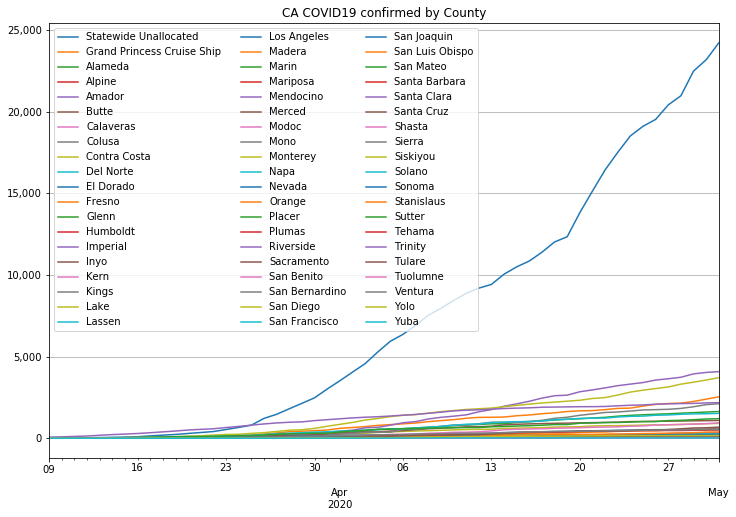

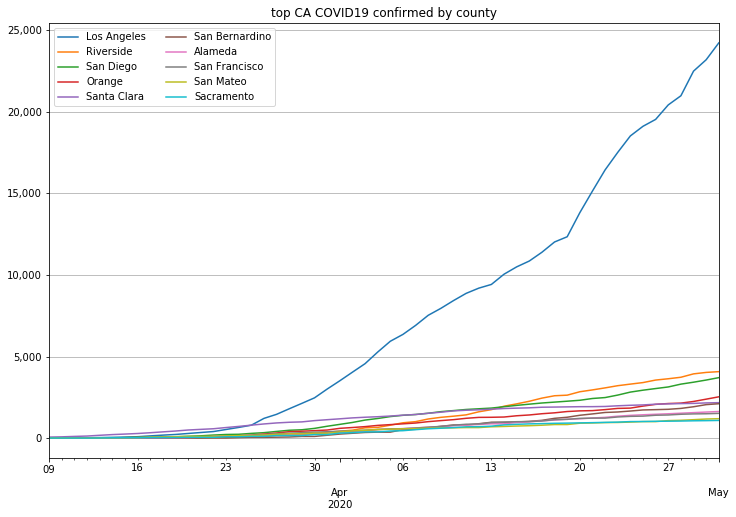

In [36]:
ax = plot_state(confirmed, 'CA')
ax.get_figure().savefig('CA_confirmed.png')

In [37]:
annotate = dict(
    s='Based on USAFacts COVID Data ({})'.format(confirmed.index.max().strftime('%B %d, %Y')), 
    xy=(0.05, 0.055), xycoords='figure fraction', fontsize=10)

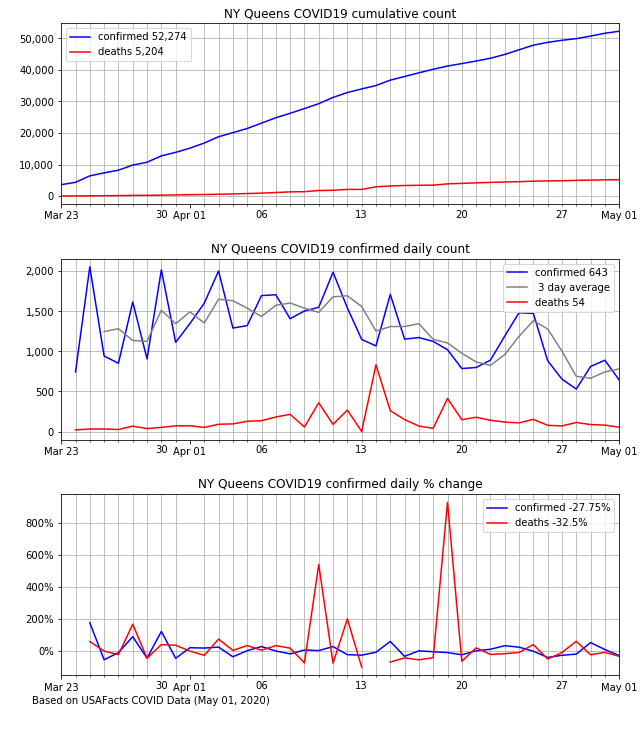

In [38]:
ax = plot_county(confirmed, deaths, 'NY','Queens')
ax[0].get_figure().savefig('Queens_COVID19_count.png')

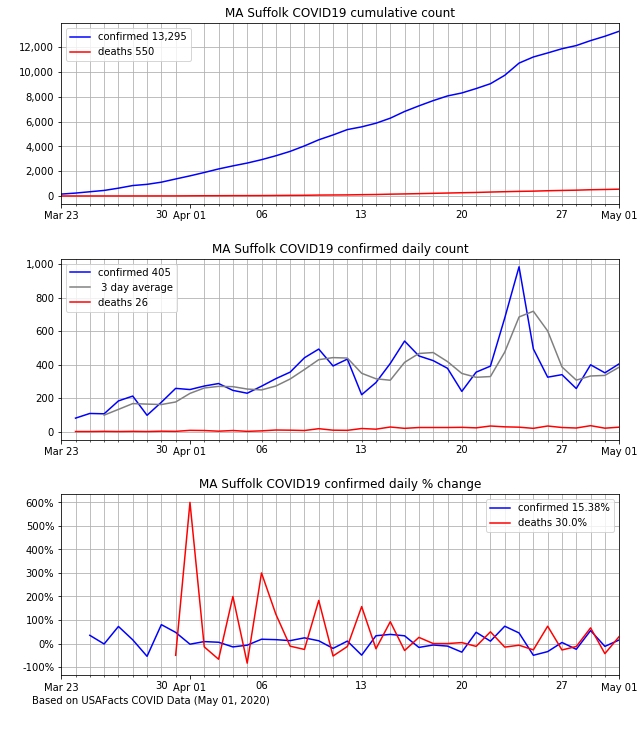

In [39]:
state = 'MA'
county = 'Suffolk'
ax = plot_county(confirmed, deaths, state, county )
ax[0].get_figure().savefig(state+'_'+county+'_COVID19_count.png')

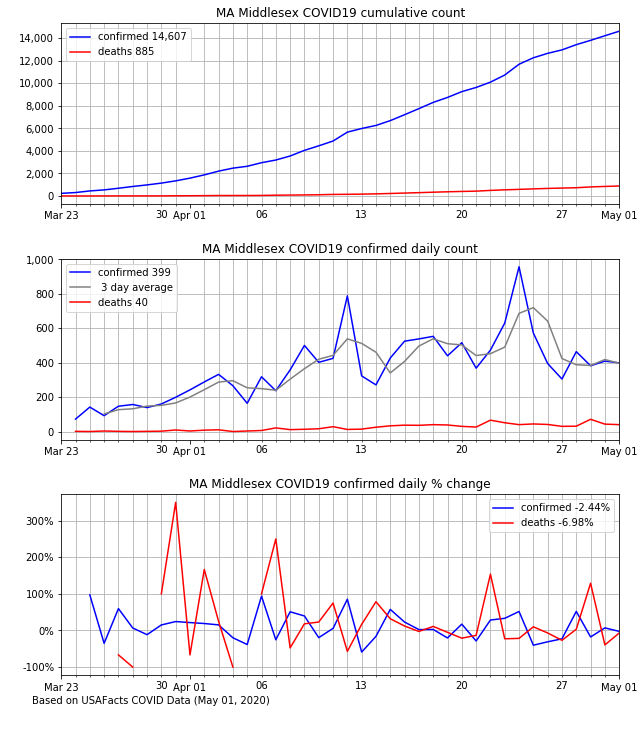

In [40]:
state = 'MA'
county = 'Middlesex'
ax = plot_county(confirmed, deaths, state, county )
ax[0].get_figure().savefig(state+'_'+county+'_COVID19_count.png')

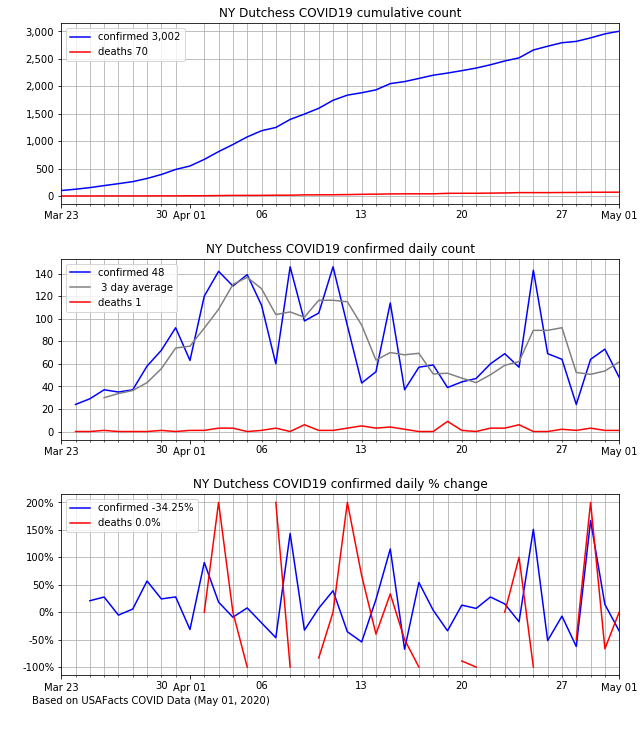

In [41]:
state = 'NY'
county = 'Dutchess'
ax = plot_county(confirmed, deaths, state, county )
ax[0].get_figure().savefig(state+'_'+county+'_COVID19_count.png')

## LogLog Plot
- [YouTube: How To Tell If We're Beating COVID-19](https://www.youtube.com/watch?v=54XLXg4fYsc) and [Graph](https://aatishb.com/covidtrends/)

In [42]:
def setup(ax):
    # from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-formatters.html
    ax.grid('on', which='major', axis='x' )
    ax.grid('on', which='major', axis='y' )
    ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [43]:
def new_total_plot(df, label='confirmed', figsize=(10,10)):
    df = df.replace(0, np.nan)
    df_diff = df.diff(axis=0).rolling(window=7).mean()
    df_diff = df_diff.replace(0.0, np.nan)

    fig, ax = plt.subplots()
    for c in df.columns:
        line = pd.DataFrame([df[c].values, df_diff[c].values])
        line = line.T
        line.columns = ['total cases',c]
        line = line[line > 10]  # line is noisy at less than 10
        line = line.dropna()    # so drop these point
        if line.shape[0] == 0:  # if line is empty, skip it
            continue
        line = line.set_index('total cases')
        line.name = c
        ax = line.plot(ax=ax, label=c, loglog=True, legend=False, figsize=figsize, c='grey') 
        last_point = line.tail(1)
        x = last_point.index[0]
        y = last_point.values[0][0]
        if x < 0:
            x = 0.0
        if y < 0:
            y = 0.0
        if x > 10 and y > 10:
            last_point.plot(ax=ax, style='ro', legend=False)
            plt.text(x,y, c)
        # ax.legend(loc='upper left', ncol=3)

    ax.set_title('Tragectory of COVID-19 '+label+' cases '+str(df.tail(1).index[0].date()))
    setup(ax)
    xticks, xticklabels = plt.xticks()
    xmin = 50
    xmax = df.max().max() + 2000
    plt.xlim(xmin, xmax)
    plt.xlabel('total '+label)
    plt.ylabel('new '+label+' (averaged over the week)')
    return ax

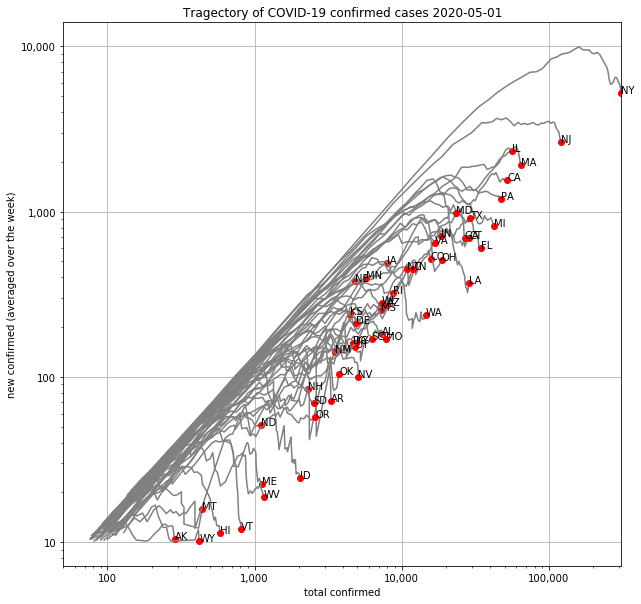

In [44]:
ax = new_total_plot(states_conf)
ax.get_figure().savefig('states_trajectory.png')

/Users/paulperry/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning: Attempting to set identical left == right == 95.0 results in singular transformations; automatically expanding.
  ax.set_xlim(left, right)


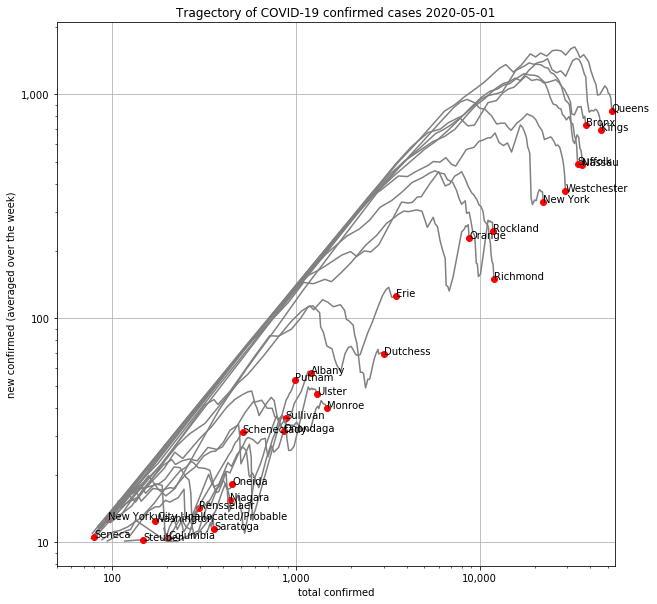

In [45]:
state='NY'
ax = new_total_plot(confirmed[state])
ax.get_figure().savefig(state+'_trajectory.png')

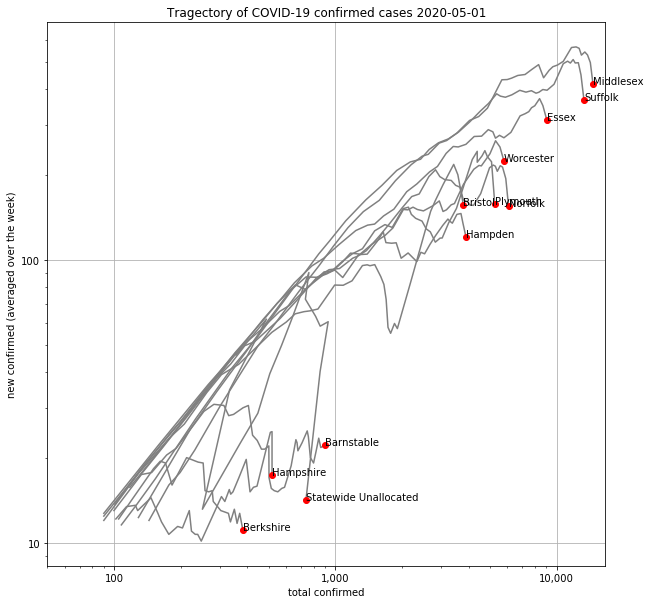

In [46]:
state='MA'
ax = new_total_plot(confirmed[state])
ax.get_figure().savefig(state+'_trajectory.png')

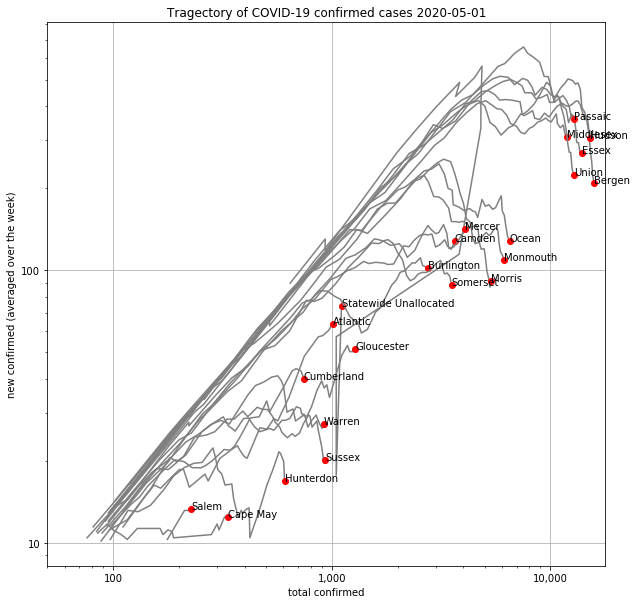

In [47]:
state='NJ'
ax = new_total_plot(confirmed[state])
ax.get_figure().savefig(state+'_trajectory.png')

## NY Data

Double check with raw data from the following sources:
-  https://coronavirus.health.ny.gov/county-county-breakdown-positive-cases
- https://www1.nyc.gov/site/doh/covid/covid-19-data.page
- https://covid19tracker.health.ny.gov/views/NYS-COVID19-Tracker/NYSDOHCOVID-19Tracker-DailyTracker?%3Aembed=yes&%3Atoolbar=no

In [48]:
ny_confirmed = confirmed['NY'].loc['2020-03-17':]
ny_deaths = deaths['NY'].loc['2020-03-17':]

In [49]:
def setup(ax, df):
    # from https://matplotlib.org/3.1.1/gallery/ticks_and_spines/tick-formatters.html
    ax.grid('on', which='major', axis='x' )
    ax.grid('on', which='major', axis='y' )
    # ax.xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(df.index.to_series().dt.strftime("%b %d")))
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

In [50]:
def plot_tot(conf, dths, area='NY'): 
    figsize=(12,6)
    label = 'confirmed '+str(format(int(conf.sum(axis=1).iloc[-1:][0]),','))
    ax = conf.sum(axis=1).plot.bar(title=area+' reported COVID-19 cases', figsize=figsize, legend=True, label=label, width=0.9)
    label = 'deaths '+str(format(int(dths.sum(axis=1).iloc[-1:][0]),','))
    ax = dths.sum(axis=1).plot.bar(color='r', legend=True, label=label, width=0.9)
    setup(ax, conf)
    return ax

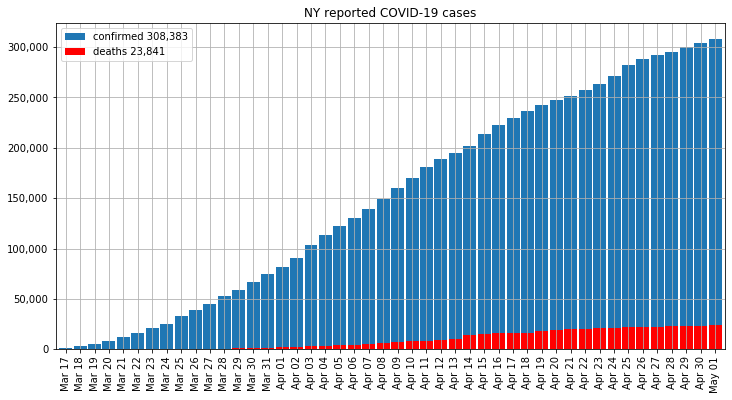

In [51]:
ax = plot_tot(ny_confirmed, ny_deaths, 'NY')

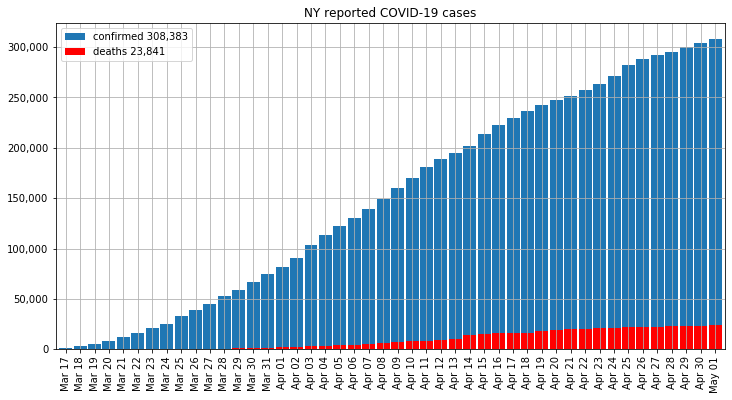

In [52]:
ax = plot_tot(ny_confirmed, ny_deaths, 'NY')

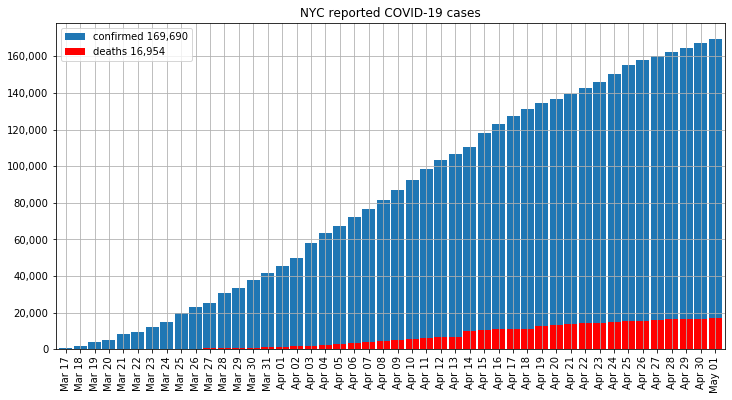

In [53]:
nyc = ['New York', 'Queens', 'Kings', 'Bronx', 'Richmond']
ax = plot_tot(ny_confirmed[nyc], ny_deaths[nyc], 'NYC')

In [54]:
def plot_diff(conf, dths, area='NY'): 
    figsize=(12,6)
    width=0.8
    label = 'confirmed '+str(format(int(conf.diff().sum(axis=1).iloc[-1:][0]),','))
    ax = conf.diff().sum(axis=1).plot.bar(title=area+' Daily new COVID-19 cases', figsize=figsize, legend=True, label=label, width=width)
    label = 'deaths '+str(format(int(dths.diff().sum(axis=1).iloc[-1:][0]),','))
    ax = dths.diff().sum(axis=1).plot.bar(color='r', legend=True, label=label, width=width)
    setup(ax, conf)
    return ax

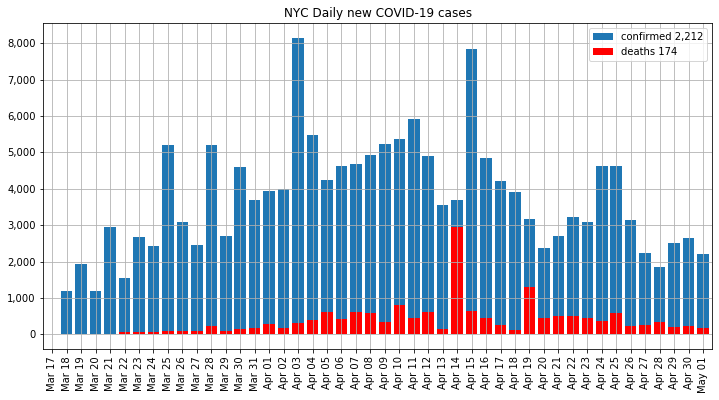

In [55]:
ax = plot_diff(ny_confirmed[nyc], ny_deaths[nyc], 'NYC')

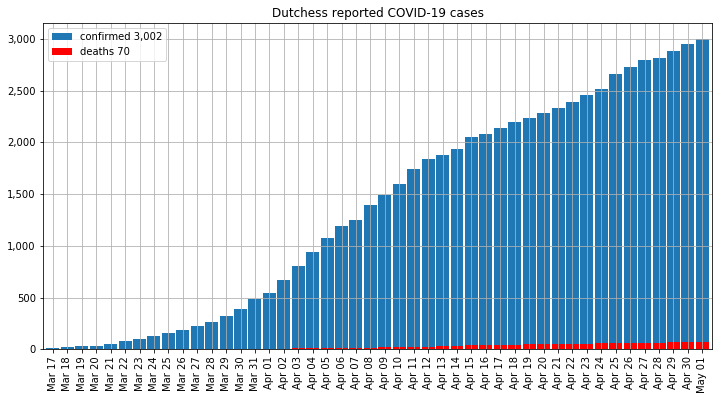

In [56]:
county = ['Dutchess']
ax = plot_tot(ny_confirmed[county], ny_deaths[county], county[0])
ax.get_figure().savefig(county[0]+'_tot.png')

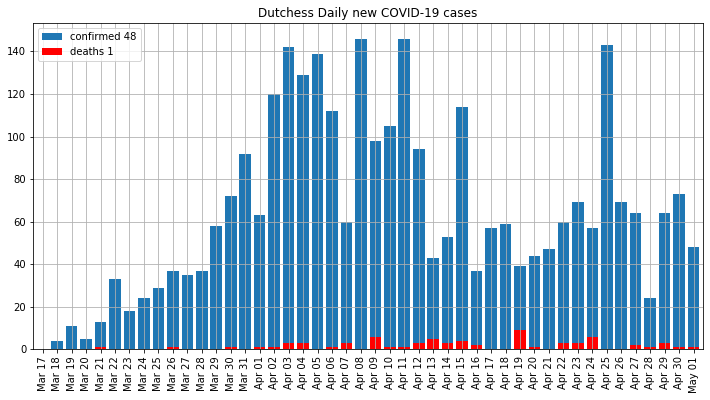

In [57]:
county = ['Dutchess']
ax = plot_diff(ny_confirmed[county], ny_deaths[county], county[0])
ax.get_figure().savefig(county[0]+'_new.png')

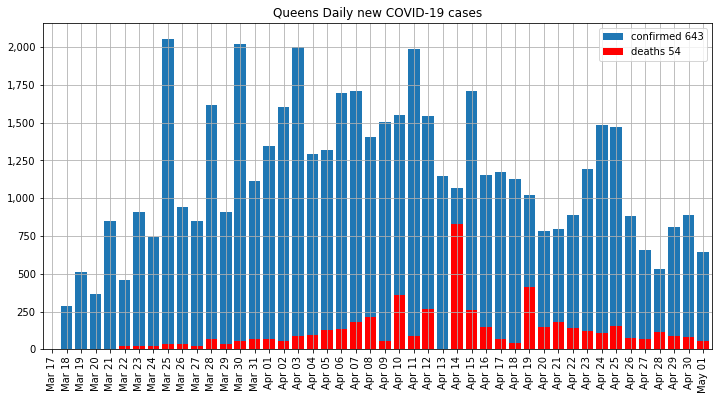

In [58]:
county = ['Queens']
ax = plot_diff(ny_confirmed[county], ny_deaths[county], county[0])

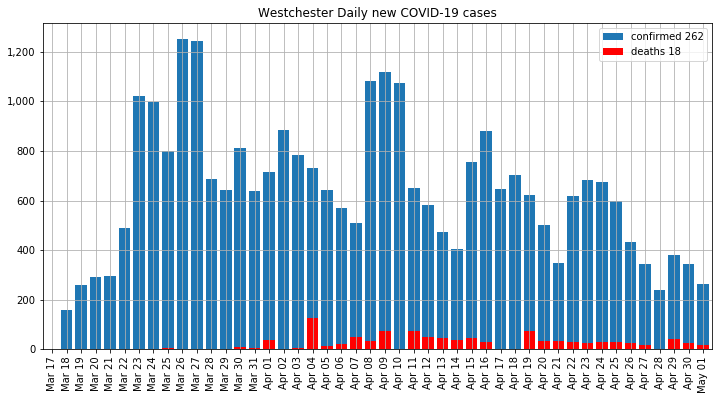

In [59]:
county = ['Westchester']
ax = plot_diff(ny_confirmed[county], ny_deaths[county], county[0])

## References

This notebook gets up-to-date data from the ["2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE"](https://systems.jhu.edu/research/public-health/ncov/) [GitHub repository](https://github.com/CSSEGISandData/COVID-19). This code is provided under the BSD-3 License. Link to [original notebook](https://github.com/paulperry/COVID-19/blob/master/covid19_eda.ipynb).↩